#### <img src="Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />
<hr style="height:2px;border:none"/>
<h1 align='center'> CIV-348 Obras Marítimas - 2019-2 </h1>

<H3 align='center'> Tarea 3   </H3>
<H3 align='center'> Diego UmañanaJ-Jorge Nuñez  </H3>
<H3 align='center'> Bastian Castro-Rodrigo Villalobo  </H3>
<hr style="height:2px;border:none"/>

## Tarea 3: Análisis de oleaje.

En esta etapa se realizará un análisis de largo plazo de parámetros estadísticos del oleaje, con el objeto de determinar la altura significativa del oleaje para períodos de retorno de `50`y `100` años. Para tal efecto, diríjase al sitio del Atlas de oleaje, y descargue la serie de tiempo de el nodo más cercano a San Antonio. Además, se entrega una base de datos similar, generada por otro grupo de análisis de datos, en el archivo adjunto `DATOS.TXT`

Luego, se pide que realice lo siguiente, para ambas series de datos, utilizando los datos de ambas bases de datos (de manera independiente), y con los casos de análisis: a) solo últimos 5 años de la muestra; b) muestra total:

i. Usando la metodología `Peak Over Threshold`, determine una altura de umbral que permita suponer un análisis estadístico confiable y con eventos independientes. Presente gráficos y comente respecto a la **variación interanual observada**, por ejemplo, en términos del número de eventos por años.

ii. Realice un ranking de los eventos, y calcule la variable reducida y la probabilidad de excedencia de acuerdo a las distribuciones Gumble, Frechet (usando k=10) y Rayleigh (Weibull, con k=2). **Entregue en una tabla los valores calculados para las 5 olas de mayor altura de su registro**.

iii. Para esas distribuciones, determine el valor de los parámetros de escala **A** y de ubicación **B**, usando ajuste vía mínimos cuadrados. Grafique los resultados indicando el coeficiente de correlación.

iv. Determine la mejor distribución, y con base en ese resultado, la altura significativa para períodos de retorno de 50 y 100 años.

v. Generar los mapas de altura-periodo, y altura-dirección. Deben usar la forma de presentarlo según EMEC, Assessment of Wave Energy Resource. Calcular además en esos mapas la potencia del oleaje.

Compare y comente los resultados que se obtienen entre ambas bases de datos, y al usar ambas ventanas de análisis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.stats as ss
import seaborn as sns

In [47]:
df = pd.read_csv('DATOS.csv')
df.head()

,year,mm,dd,hh,Hm0,MDir,ThTp,Tp,Tm-10,Tm01,Tm02,WINDSP,WDIR,date
0,1989,9,1,0,2.78,225.9,229.0,13.66,10.83,8.70,7.33,9.37,178.5,1989-09-01 00:00:00
1,1989,9,1,3,2.93,223.6,229.5,13.63,10.49,8.46,7.26,9.62,184.3,1989-09-01 03:00:00
2,1989,9,1,6,3.02,222.5,229.7,13.62,10.34,8.35,7.22,9.74,186.1,1989-09-01 06:00:00
3,1989,9,1,9,2.99,224.8,230.2,13.69,10.78,8.84,7.66,9.74,181.8,1989-09-01 09:00:00
4,1989,9,1,12,2.97,227.0,230.6,13.76,11.19,9.36,8.15,9.74,177.6,1989-09-01 12:00:00


In [48]:
df = pd.read_csv('DATOS.csv')
df["date"] = pd.to_datetime(df["date"])

indexdf=df["date"]
mes = list(df["mm"])
dia = list(df["dd"])
Hm0 = list(df["Hm0"])
MDir = list(df["MDir"])
ThTp = list(df["ThTp"])
Tp = list(df["Tp"])
Tm10=list(df["Tm-10"])
Tm01=list(df["Tm01"])
Tm02=list(df["Tm02"])
WINDSP=list(df["WINDSP"])
WDIR=list(df["WDIR"])

d = {'mm':mes,'dd':dia,'Hm0':Hm0 ,'MDir':MDir ,'ThTp': ThTp,'Tp': Tp,'Tm10': Tm10,'Tm01': Tm01,'Tm02':Tm02 ,'WINDSP': WINDSP,'WDIR': WDIR}
df = pd.DataFrame(data=d, index= indexdf)

## Parámetros Integrados del Espectro.

    LONG    -73.5 deg                               
    LAT     -33.0 deg 
#### Descripción del DataFrame DATOS.
Esta data contiene los registros de oleaje horario desde los años 1989 hasta 2011.


|Columns                    | Descripción                           |
|:------------------------- |:------------------------------------- |
|Hm0    [m]              | Altura Significativa Espectral |
| MDir [deg]              | Direccion media   |
|  ThTp [deg]           |   Direccion Media del periodo pico  |
|Tp [s]| Periodo pico |
|Tm-10 [s]|Periodo energia|
|Tm01 [s]|Periodo medio |
|Tm02 [s]|Periodo de cruces por cero (= Tz) |
|WINDSP [m/s] |Velocidad del viento a 10 m de altura|
|WDIR [deg]|Direccion media del viento a 10 m altura|

Direcciones medidas en sentido horario desde el Norte 

i. Sin datos se indica con   -1

ii. Periodos < 2.0 se marcan como sin datos

In [4]:
#df=df['2007':'2011'] #para 5 años

In [49]:
df.describe()

,mm,dd,Hm0,MDir,ThTp,Tp,Tm10,Tm01,Tm02,WINDSP,WDIR
count,58428.000000,58428.000000,58428.000000,58428.000000,58428.000000,58428.000000,58428.000000,58428.000000,58428.000000,58428.000000,58428.000000
mean,6.523567,15.727066,2.685801,227.426039,228.471774,12.573344,10.373165,8.899045,7.948131,7.112156,205.155768
std,3.448544,8.799146,0.835707,17.679328,23.775953,2.185589,1.553673,1.617556,1.627474,3.360109,54.579934
min,1.000000,1.000000,0.650000,184.300000,0.000000,5.120000,6.320000,4.990000,4.230000,0.010000,0.000000
25%,4.000000,8.000000,2.060000,214.800000,215.700000,11.450000,9.200000,7.600000,6.630000,4.460000,184.300000
50%,7.000000,16.000000,2.610000,225.200000,225.200000,12.800000,10.320000,8.750000,7.690000,7.350000,192.800000
75%,10.000000,23.000000,3.210000,237.100000,234.200000,13.980000,11.450000,10.060000,9.130000,9.710000,206.700000
max,12.000000,31.000000,6.580000,353.500000,359.300000,23.940000,17.590000,16.190000,15.250000,22.220000,360.000000


## Ola de mayor altura

In [57]:
df[df['Hm0']>6.5]

,mm,dd,Hm0,MDir,ThTp,Tp,Tm10,Tm01,Tm02,WINDSP,WDIR
date,,,,,,,,,,,
2003-10-31 12:00:00,10,31,6.58,201.3,214.1,11.18,10.38,9.05,8.16,15.54,174.6


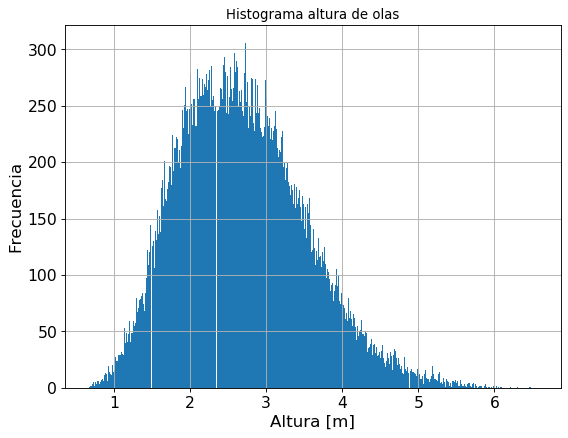

<Figure size 432x288 with 0 Axes>

In [6]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Histograma altura de olas')
plt.hist(df['Hm0'], bins = 600)
plt.grid(True)
plt.xlabel('Altura [m]',fontsize=15)
plt.ylabel('Frecuencia',fontsize=15)
plt.show()
plt.clf()

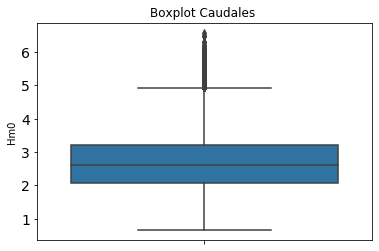

In [7]:
sns.boxplot(df['Hm0'], labels=["Matriz frases"],orient='v')
plt.title("Boxplot Caudales ")
plt.show()

**Comentario:** Se realiza boxplot de las alturas de oleaje para estimar el valor del umbral aproximado, y luego corroborarlo con la metodología explicada mas abajo.

## Variación Interanual Observada

In [8]:
umbr= 4.8
#xu = pd.to_datetime(['2007-01-01 00:00:00','2011-08-31 18:00:00'])# para 5 años
xu = pd.to_datetime(['1993-01-01 00:00:00','2011-08-31 18:00:00'])
yu = [1*umbr,1*umbr]
Hm0_extr = df[df['Hm0'] >= umbr]
Hm0_extr.describe()
cant = len(Hm0_extr)

In [9]:
Hm0_extr

,mm,dd,Hm0,MDir,ThTp,Tp,Tm10,Tm01,Tm02,WINDSP,WDIR
date,,,,,,,,,,,
1989-10-26 21:00:00,10,26,4.91,204.7,229.6,12.21,8.84,7.60,6.80,14.16,178.7
1989-10-27 00:00:00,10,27,4.95,204.0,229.0,12.19,8.85,7.63,6.84,14.61,179.9
1989-10-27 03:00:00,10,27,4.93,203.6,228.7,12.16,8.85,7.64,6.85,14.63,179.1
1989-10-27 06:00:00,10,27,4.86,202.0,227.4,12.02,8.87,7.70,6.92,14.64,178.3
1990-01-17 12:00:00,1,17,4.80,196.9,177.2,8.73,8.63,7.50,6.79,15.06,168.6
...,...,...,...,...,...,...,...,...,...,...,...
2011-07-01 00:00:00,7,1,4.96,193.6,199.5,13.62,10.17,8.60,7.64,14.86,173.5
2011-07-01 03:00:00,7,1,4.98,194.9,199.9,13.97,10.49,8.78,7.76,14.64,176.0
2011-07-01 06:00:00,7,1,4.99,195.3,200.0,14.15,10.59,8.85,7.80,14.32,178.5


**Comentario:** Se extaren todos los registros que estan por encima del umbral impuesto, del cual quedaron 796 registros que estan sobre los 4.2 metros de altura, estos no asuguran ser eventos independientes y se puede corroborar con las fechas en la que algunos ocurren con tan solo horas de diferencia.

In [10]:
i=1
cont=0
while 1:
    mes = (Hm0_extr.iloc[i]['mm']-Hm0_extr.iloc[i-1]['mm'])==0
    day=(Hm0_extr.iloc[i]['dd']-Hm0_extr.iloc[i-1]['dd'])>=2
    alt=(Hm0_extr.iloc[i]['Hm0'])>=(Hm0_extr.iloc[i-1]['Hm0'])
    if mes==True:
        if day==False :
            if alt == True:
                Hm0_extr=Hm0_extr.drop(index=Hm0_extr.index[i-1],axis=0)
                i=i-2
            if alt == False:
                Hm0_extr=Hm0_extr.drop(index=Hm0_extr.index[i],axis=0)
                i=i-2
    i=i+1
    cont=cont+1
    if i==len(Hm0_extr):
        break
print(cont)
print(i)

1480
145


In [11]:
Hm0_extr

,mm,dd,Hm0,MDir,ThTp,Tp,Tm10,Tm01,Tm02,WINDSP,WDIR
date,,,,,,,,,,,
1989-10-27 00:00:00,10,27,4.95,204.0,229.0,12.19,8.85,7.63,6.84,14.61,179.9
1990-01-18 00:00:00,1,18,5.30,201.1,195.3,9.23,8.73,7.66,6.95,14.70,186.9
1990-01-31 03:00:00,1,31,4.82,218.7,308.8,17.45,9.46,7.81,6.94,13.15,194.3
1990-03-30 00:00:00,3,30,5.05,223.3,221.7,15.47,13.83,12.69,11.78,4.59,166.0
1990-07-28 06:00:00,7,28,5.19,203.6,231.0,13.75,9.30,7.85,6.99,15.47,176.3
...,...,...,...,...,...,...,...,...,...,...,...
2011-04-22 18:00:00,4,22,5.30,226.8,220.0,15.91,14.11,12.92,12.09,5.23,161.9
2011-06-08 18:00:00,6,8,5.40,234.1,234.1,16.42,14.96,13.97,13.29,3.18,235.8
2011-06-20 00:00:00,6,20,5.47,313.6,335.0,9.32,9.80,8.66,7.90,16.27,347.8


**Comentario:** Para asegurar la independencia de los eventos se realiza una rutina en la cual se van comparando dos eventos consecutivos y se verifica que ocurran con mas de 48 horas de diferencia conservado el registro de mayor altura, una vez realizdo esto de los 796 registros anteriores tán solo quedaron 111 eventos los cuales son suficientes para realizar un estudio estadistico confiable.

/home/lenovio/anaconda3/envs/MachineLearning/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


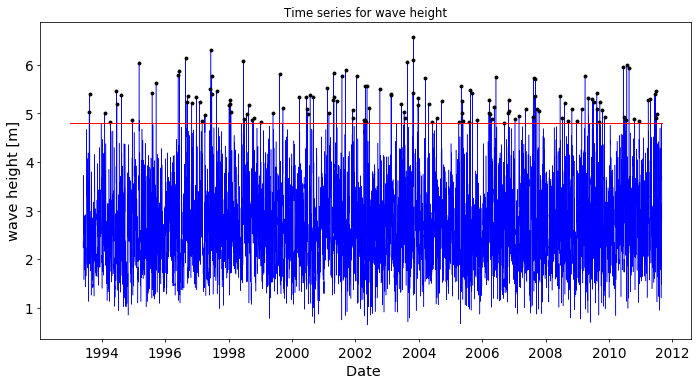

In [12]:
fig = plt.figure(figsize=(12,6), dpi=70)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Time series for wave height')
#plt.plot(df['Hm0']['2007':'2011'],'b',linewidth=0.5)
#plt.plot(Hm0_extr['Hm0']['2007':'2011'],'k.') # para 5 años
plt.plot(df['Hm0']['1993':'2011'],'b',linewidth=0.5)
plt.plot(Hm0_extr['Hm0']['1993':'2011'],'k.')
plt.plot(xu,yu,'r',linewidth=1)
plt.xlabel('Date ',fontsize=15)
plt.ylabel('wave height [m]',fontsize=15)
plt.show()

In [13]:
Hm0_extr.describe()


,mm,dd,Hm0,MDir,ThTp,Tp,Tm10,Tm01,Tm02,WINDSP,WDIR
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,6.489655,16.806897,5.261310,225.900000,229.806897,13.492828,11.109241,9.568552,8.555517,11.718621,207.546897
std,2.988676,8.758565,0.364884,36.187536,37.943129,2.974979,2.004487,1.911056,1.827480,3.678549,56.785875
min,1.000000,1.000000,4.810000,194.100000,175.700000,8.270000,8.260000,7.450000,6.690000,1.250000,11.500000
25%,4.000000,10.000000,4.990000,204.500000,208.600000,10.280000,9.500000,8.160000,7.350000,9.520000,178.700000
50%,6.000000,17.000000,5.210000,212.700000,222.300000,14.340000,10.430000,8.820000,7.730000,12.790000,184.600000
75%,9.000000,24.000000,5.420000,231.200000,230.800000,15.910000,12.530000,10.470000,9.160000,14.370000,197.100000
max,12.000000,31.000000,6.580000,353.500000,357.600000,18.160000,15.990000,14.930000,14.130000,17.590000,357.800000


In [14]:
np.linspace(1989,2011,23)

array([1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011.])

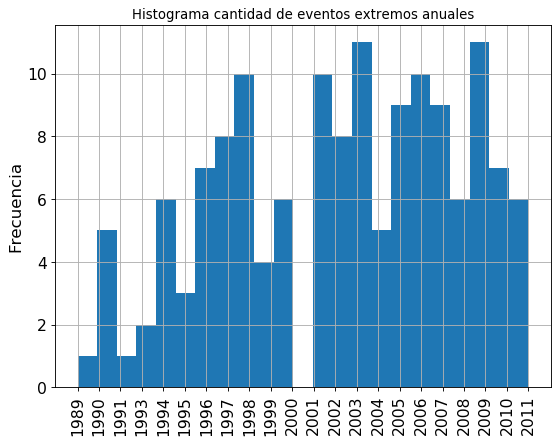

<Figure size 432x288 with 0 Axes>

In [15]:
#años = np.linspace(2007,2011,5) #5 años
años = np.linspace(1989,2011,23)
Q_años = []
for i in años:
    Q=len(Hm0_extr.loc[str(int(i))])
    for j in range (Q):
        Q_años.append(str(int(i)))


fig = plt.figure(figsize=(8,6), dpi=80)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Histograma cantidad de eventos extremos anuales')
plt.hist(Q_años, bins = 23)
plt.grid(True)
plt.ylabel('Frecuencia',fontsize=15)
plt.xticks(rotation='vertical')
plt.show()
plt.clf()

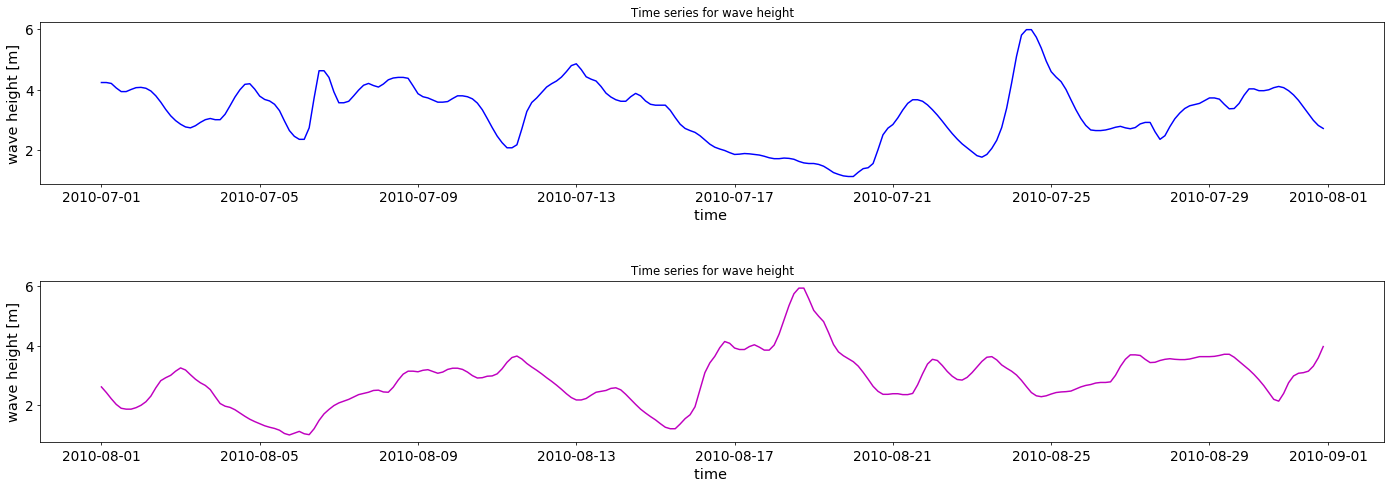

<Figure size 432x288 with 0 Axes>

In [16]:

fig = plt.figure(figsize=(12,6), dpi=70)
plt.subplot(2,1,1)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Time series for wave height')
plt.plot(df['Hm0'].loc['2010-07'],'b')
plt.xlabel('time ',fontsize=15)
plt.ylabel('wave height [m]',fontsize=15)

plt.subplot(2,1,2)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Time series for wave height')
plt.plot(df['Hm0'].loc['2010-08'],'m')
plt.xlabel('time ',fontsize=15)
plt.ylabel('wave height [m]',fontsize=15)

plt.subplots_adjust(top=4, bottom=3, left=0.4, right=2, hspace=0.6,
                    wspace=0.2)
plt.show()
plt.clf()

## Probabilidades de Excedencia y Variable Reducida
* Ordenar valores de mayor a menor (numero de orden m)
* Probabilidad de la muestra

$$P(x<x_{m})= \hat{F}_{(m)}=1 - \frac{m-\alpha}{N_{T}+\beta}$$

In [17]:
H_desc=Hm0_extr.sort_values(by=['Hm0'], ascending=False)['Hm0']

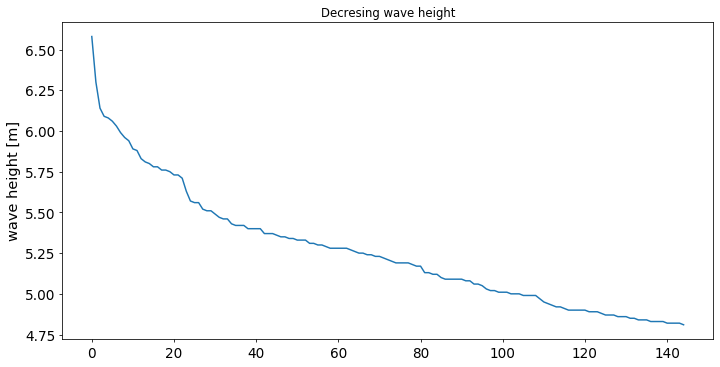

In [18]:
fig = plt.figure(figsize=(12,6), dpi=70)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Decresing wave height')
plt.plot(list(H_desc))
plt.ylabel('wave height [m]',fontsize=15)
plt.show()

In [19]:
H_desc.iloc[0]

6.58

**Comenatrio:** con el comando .iloc[i], podemos obtener el valor numerico en la posición 'i', i=0 es el mayor valor e i=n-1 es el valor o altura de ola mas pequeña.

$$P_{exc}=P(x>=x_{m})= 1-P_{muestra}= \frac{m-\alpha}{N_{T}+\beta}$$
donde:
* m = posición del evento.
* $N_{T}$ = cantidad total de registros.
* $\alpha$ y $\beta$ =  parametros que dependen de la distribución. 

In [20]:
H_desc.head(5)

date
2003-10-31 12:00:00    6.58
1997-06-11 06:00:00    6.30
1996-08-23 18:00:00    6.14
2003-11-01 00:00:00    6.09
1998-06-21 12:00:00    6.08
Name: Hm0, dtype: float64

**Coementario:** En la tabla anterior se presentán los 5 eventos más importantes o de mayor altura de oleaje con sus respectivas fechas de ocurrencia. 

#### I. Gumbel
* $\alpha$ = 0.49
* $\beta$ = 0.11

In [21]:
alpha_G = 0.49
beta_G = 0.11
Nt = len(H_desc)
H_G = []
Pexc_G = []
ym_G = []
for i in range(5):
    pexc_G = (i+1-alpha_G)/(Nt+beta_G)
    H_G.append(H_desc.iloc[i])
    Pexc_G.append(pexc_G)
    ym_G.append(-np.log(-np.log(1-pexc_G)))
gum = {'Altura de ola [m]':H_G, 'Pexc':Pexc_G, 'ym [m]':ym_G}
Gumbel = pd.DataFrame(data=gum)

In [22]:
Gumbel

,Altura de ola [m],Pexc,ym [m]
0,6.58,0.003515,5.649077
1,6.30,0.010406,4.560157
2,6.14,0.017297,4.048498
3,6.09,0.024189,3.709658
4,6.08,0.031080,3.455450


## II. Frechet (k = 10)
* $\alpha = 0.44 + 0.52/k$
* $\beta = 0.12 - 0.11/k$

In [23]:
k = 10
alpha_F = 0.44+0.52/k
beta_F = 0.12-0.11/k
Nt = len(H_desc)
H_F = []
Pexc_F = []
ym_F = []
for i in range(5):
    pexc_F = (i+1-alpha_F)/(Nt+beta_F)
    H_F.append(H_desc.iloc[i])
    Pexc_F.append(pexc_F)
    ym_F.append(10*(((-np.log(1-pexc_F))**-0.1)-1))
fre = {'Altura de ola [m]':H_F, 'Pexc':Pexc_F, 'ym [m]':ym_F}
Frechet = pd.DataFrame(data=fre)

In [24]:
Frechet

,Altura de ola [m],Pexc,ym [m]
0,6.58,0.003501,7.599768
1,6.30,0.010392,5.779842
2,6.14,0.017284,4.991968
3,6.09,0.024175,4.492161
4,6.08,0.031066,4.128223


## III. Rayleigh (Weibull, k=2)

* $\alpha = 0.20 + 0.27/\sqrt{k}$
* $\beta = 0.20 + 0.23/\sqrt{k}$

In [25]:
k = 2
alpha_R = 0.20+0.27/(k)**0.5
beta_R = 0.20+0.23/(k)**0.5
Nt = len(H_desc)
H_R = []
Pexc_R = []
ym_R = []
for i in range(5):
    pexc_R = (i+1-alpha_R)/(Nt+beta_R)
    H_R.append(H_desc.iloc[i])
    Pexc_R.append(pexc_R)
    ym_R.append((-np.log(pexc_R))**0.5)
ray = {'Altura de ola [m]':H_R, 'Pexc':Pexc_R, 'ym [m]':ym_R}
Rayleigh = pd.DataFrame(data=ray)

In [26]:
Rayleigh

,Altura de ola [m],Pexc,ym [m]
0,6.58,0.004190,2.339879
1,6.30,0.011069,2.122161
2,6.14,0.017949,2.005052
3,6.09,0.024828,1.922441
4,6.08,0.031707,1.857741


## Parámetros de Escala y de Ubicación según Distribución de Probabilidad

La variable reducida $y_{m}$ se relaciona con $x_{m}$ linealmente como se presenta en la siguiente ecuación.
$$y_{m}=\frac{x_{m}-B}{A}\Rightarrow x_{m}= A*y_{m}+B$$
donde A y B son los parámetros de escala y ubicación respectivamente.

#### Gumbel.

In [27]:
alpha_G = 0.49
beta_G = 0.11
Nt = len(H_desc)
H_G = []
Pexc_G = []
ym_G = []
for i in range(Nt):
    pexc_G = (i+1-alpha_G)/(Nt+beta_G)
    H_G.append(H_desc.iloc[i])
    Pexc_G.append(pexc_G)
    ym_G.append(-np.log(-np.log(1-pexc_G)))
gum = {'Altura de ola [m]':H_G, 'Pexc':Pexc_G, 'ym [m]':ym_G}
Gumbel = pd.DataFrame(data=gum)

In [28]:
Gumbel

,Altura de ola [m],Pexc,ym [m]
0,6.58,0.003515,5.649077
1,6.30,0.010406,4.560157
2,6.14,0.017297,4.048498
3,6.09,0.024189,3.709658
4,6.08,0.031080,3.455450
...,...,...,...
140,4.82,0.968300,-1.238790
141,4.82,0.975191,-1.307402
142,4.82,0.982083,-1.391774
143,4.82,0.988974,-1.505740


In [29]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
x = Gumbel['ym [m]'] 
y = Gumbel['Altura de ola [m]']
# Creo un modelo de regresión lineal
modelo = linear_model.LinearRegression()
 
# Entreno el modelo con los datos (X,Y)
modelo.fit(x.values.reshape(-1,1),y.values.reshape(-1,1))
# Ahora puedo obtener el coeficiente b_1
print ('Coeficiente beta1: ', modelo.coef_[0])
print('Intercepto: ',modelo.intercept_ )

A_G =  modelo.coef_[0]
B_G = modelo.intercept_ 
# Podemos predecir usando el modelo
y_pred = modelo.predict(x.values.reshape(-1,1))
 
# Por último, calculamos el error cuadrático medio y el estadístico R^2
print ('Error cuadrático medio: %.2f' , mean_squared_error(y, y_pred))
print ('Estadístico R_2: %.2f' , r2_score(y, y_pred))
r2_G =r2_score(y, y_pred)

Coeficiente beta1:  [0.28450938]
Intercepto:  [5.09730674]
Error cuadrático medio: %.2f 0.0022220865941055988
Estadístico R_2: %.2f 0.9831943283255677


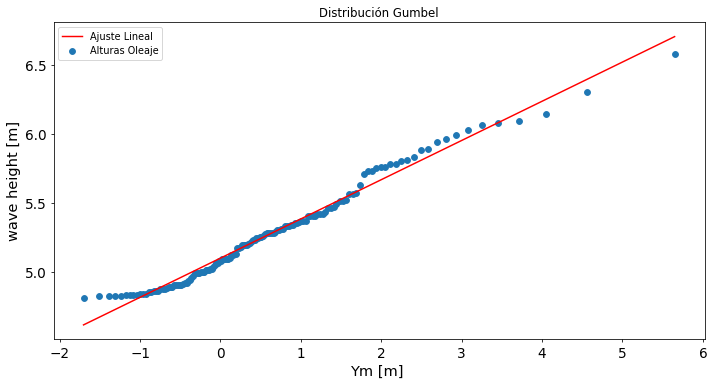

In [30]:
fig = plt.figure(figsize=(12,6), dpi=70)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Distribución Gumbel')
plt.scatter(x, y,label = 'Alturas Oleaje')
plt.plot(x, y_pred, color='red', label='Ajuste Lineal')
plt.xlabel('Ym [m] ',fontsize=15)
plt.ylabel('wave height [m]',fontsize=15)
plt.legend(loc='upper left')
plt.show()


#### Frechet

In [31]:
k = 10
alpha_F = 0.44+0.52/k
beta_F = 0.12-0.11/k
Nt = len(H_desc)
H_F = []
Pexc_F = []
ym_F = []
for i in range(Nt):
    pexc_F = (i+1-alpha_F)/(Nt+beta_F)
    H_F.append(H_desc.iloc[i])
    Pexc_F.append(pexc_F)
    ym_F.append(10*(((-np.log(1-pexc_F))**-0.1)-1))
fre = {'Altura de ola [m]':H_F, 'Pexc':Pexc_F, 'ym [m]':ym_F}
Frechet = pd.DataFrame(data=fre)

In [32]:
Frechet

,Altura de ola [m],Pexc,ym [m]
0,6.58,0.003501,7.599768
1,6.30,0.010392,5.779842
2,6.14,0.017284,4.991968
3,6.09,0.024175,4.492161
4,6.08,0.031066,4.128223
...,...,...,...
140,4.82,0.968293,-1.165076
141,4.82,0.975184,-1.225476
142,4.82,0.982076,-1.299179
143,4.82,0.988967,-1.397739


In [33]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
x = Frechet['ym [m]'] 
y = Frechet['Altura de ola [m]']
# Creo un modelo de regresión lineal
modelo = linear_model.LinearRegression()
 
# Entreno el modelo con los datos (X,Y)
modelo.fit(x.values.reshape(-1,1),y.values.reshape(-1,1))
# Ahora puedo obtener el coeficiente b_1
print ('Coeficiente beta1: ', modelo.coef_[0])
print('Intercepto: ',modelo.intercept_ )

A_F = modelo.coef_[0]
B_F = modelo.intercept_ 
 
# Podemos predecir usando el modelo
y_pred = modelo.predict(x.values.reshape(-1,1))
 
# Por último, calculamos el error cuadrático medio y el estadístico R^2
print ('Error cuadrático medio: %.2f' , mean_squared_error(y, y_pred))
print ('Estadístico R_2: %.2f' , r2_score(y, y_pred))

r2_F =r2_score(y, y_pred)


Coeficiente beta1:  [0.24606111]
Intercepto:  [5.09329047]
Error cuadrático medio: %.2f 0.003911187988169993
Estadístico R_2: %.2f 0.9704196310978489


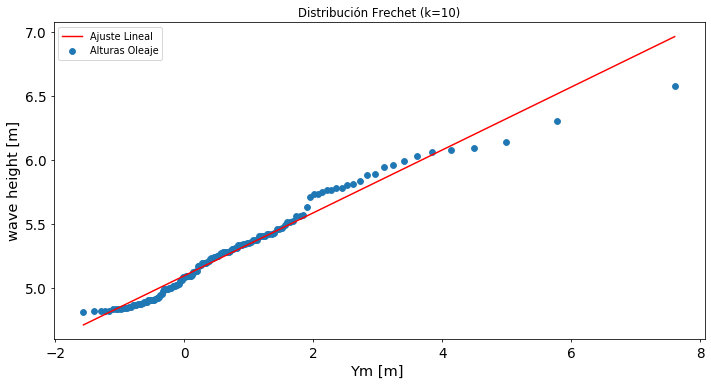

In [34]:
fig = plt.figure(figsize=(12,6), dpi=70)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Distribución Frechet (k=10)')
plt.scatter(x, y,label = 'Alturas Oleaje')
plt.plot(x, y_pred, color='red', label='Ajuste Lineal')
plt.xlabel('Ym [m] ',fontsize=15)
plt.ylabel('wave height [m]',fontsize=15)
plt.legend(loc='upper left')
plt.show()

#### Rayleigh (Weibull, k=2)

In [35]:
k = 2
alpha_R = 0.20+0.27/(k)**0.5
beta_R = 0.20+0.23/(k)**0.5
Nt = len(H_desc)
H_R = []
Pexc_R = []
ym_R = []
for i in range(Nt):
    pexc_R = (i+1-alpha_R)/(Nt+beta_R)
    H_R.append(H_desc.iloc[i])
    Pexc_R.append(pexc_R)
    ym_R.append((-np.log(pexc_R))**0.5)
ray = {'Altura de ola [m]':H_R, 'Pexc':Pexc_R, 'ym [m]':ym_R}
Rayleigh = pd.DataFrame(data=ray)

In [36]:
Rayleigh

,Altura de ola [m],Pexc,ym [m]
0,6.58,0.004190,2.339879
1,6.30,0.011069,2.122161
2,6.14,0.017949,2.005052
3,6.09,0.024828,1.922441
4,6.08,0.031707,1.857741
...,...,...,...
140,4.82,0.967299,0.182340
141,4.82,0.974178,0.161744
142,4.82,0.981057,0.138291
143,4.82,0.987937,0.110166


In [37]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
x = Rayleigh['ym [m]'] 
y = Rayleigh['Altura de ola [m]']
# Creo un modelo de regresión lineal
modelo = linear_model.LinearRegression()
 
# Entreno el modelo con los datos (X,Y)
modelo.fit(x.values.reshape(-1,1),y.values.reshape(-1,1))
# Ahora puedo obtener el coeficiente b_1
print ('Coeficiente beta1: ', modelo.coef_[0])
print('Intercepto: ',modelo.intercept_ )

A_R = modelo.coef_[0]
B_R = modelo.intercept_ 
 
# Podemos predecir usando el modelo
y_pred = modelo.predict(x.values.reshape(-1,1))
 
# Por último, calculamos el error cuadrático medio y el estadístico R^2
print ('Error cuadrático medio: %.2f' , mean_squared_error(y, y_pred))
print ('Estadístico R_2: %.2f' , r2_score(y, y_pred))
r2_R=r2_score(y, y_pred)

Coeficiente beta1:  [0.78504089]
Intercepto:  [4.56575293]
Error cuadrático medio: %.2f 0.002772235327620241
Estadístico R_2: %.2f 0.9790335458375777


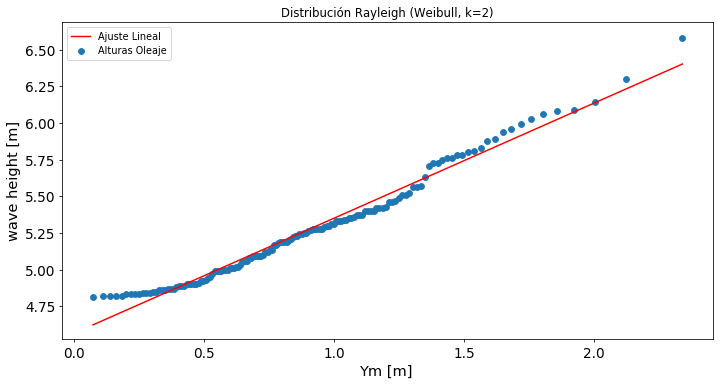

In [38]:
fig = plt.figure(figsize=(12,6), dpi=70)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.title('Distribución Rayleigh (Weibull, k=2)')
plt.scatter(x, y,label = 'Alturas Oleaje')
plt.plot(x, y_pred, color='red', label='Ajuste Lineal')
plt.xlabel('Ym [m] ',fontsize=15)
plt.ylabel('wave height [m]',fontsize=15)
plt.legend(loc='upper left')
plt.show()

#### Tabla resumen resultados ajustes lineales.



In [39]:
dis = {'Distribución':['Gumbel','Frechet','Rayleigh'], 'A':(A_G[0],A_F[0],A_R[0]), 'B':[B_G[0],B_F[0],B_R[0]], 'R²':[r2_G,r2_F,r2_R]}
tabla = pd.DataFrame(data=dis)

In [40]:
tabla

,Distribución,A,B,R²
0,Gumbel,0.284509,5.097307,0.983194
1,Frechet,0.246061,5.093290,0.970420
2,Rayleigh,0.785041,4.565753,0.979034


**Comentario:** En base a los resultados obtenidos la distribución que mejor se ajusta a los resgistros en estudio es la Gumbel mediante elcriterio de R² el cual indica que tan bien se ajustan los datos a la regresion realizada.

## Altura Significativa del Oleaje según Periodo de Retorno (Gumbel)
Determine la mejor distribución, y con base en ese resultado, la altura significativa para períodos de retorno de 50 y 100 años.

$$H = x_{m}=A*y_{m} + B$$
$$y_{m}=-ln(-ln(1-P_{exc}))$$
$$P_{exc} = \frac{1}{T}$$


In [41]:
A= A_G[0]
B = B_G[0]
T1 = 50
T2 =100
ym_G1 = -np.log(-np.log(1-1/T1))
ym_G2 = -np.log(-np.log(1-1/T2))
H1 = A*ym_G1+B
H2 = A*ym_G2+B
print('altura T=50 :',H1)
print('altura T=100 :',H2)

altura T=50 : 6.207444883275014
altura T=100 : 6.4060923385023525


## Mapas Altura-Periodo y Altura-Dirección (EMEC)

In [42]:
i = 180
j=225
Dir_x = df[i<df['MDir']]
Dir_x = df[j>df['MDir']]

In [43]:
len(Dir_x)

28833

In [44]:
df

,mm,dd,Hm0,MDir,ThTp,Tp,Tm10,Tm01,Tm02,WINDSP,WDIR
date,,,,,,,,,,,
1989-09-01 00:00:00,9,1,2.78,225.9,229.0,13.66,10.83,8.70,7.33,9.37,178.5
1989-09-01 03:00:00,9,1,2.93,223.6,229.5,13.63,10.49,8.46,7.26,9.62,184.3
1989-09-01 06:00:00,9,1,3.02,222.5,229.7,13.62,10.34,8.35,7.22,9.74,186.1
1989-09-01 09:00:00,9,1,2.99,224.8,230.2,13.69,10.78,8.84,7.66,9.74,181.8
1989-09-01 12:00:00,9,1,2.97,227.0,230.6,13.76,11.19,9.36,8.15,9.74,177.6
...,...,...,...,...,...,...,...,...,...,...,...
2011-08-31 06:00:00,8,31,3.70,221.9,226.3,15.91,13.22,10.81,8.89,7.57,187.3
2011-08-31 09:00:00,8,31,3.69,222.0,226.3,15.91,13.23,10.84,8.91,6.52,181.5
2011-08-31 12:00:00,8,31,3.57,222.5,226.1,15.95,13.38,11.17,9.25,5.78,173.8


/home/lenovio/anaconda3/envs/MachineLearning/lib/python3.7/site-packages/windrose/windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
/home/lenovio/anaconda3/envs/MachineLearning/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/home/lenovio/anaconda3/envs/MachineLearning/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/home/lenovio/anaconda3/envs/MachineLearning/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDe

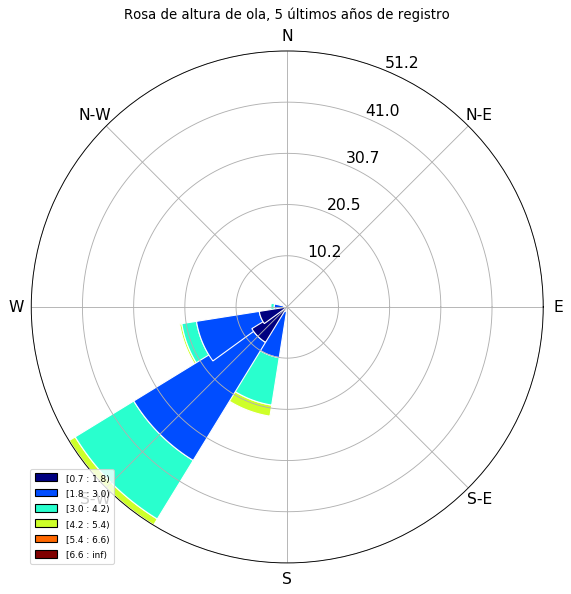

In [45]:
import matplotlib.cm as cm
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(df['MDir'], df['Hm0'], normed=True, opening=1.2, edgecolor='white')
plt.title('Rosa de altura de ola, 5 últimos años de registro')
ax.set_legend()
plt.show()


## Potencia de oleaje

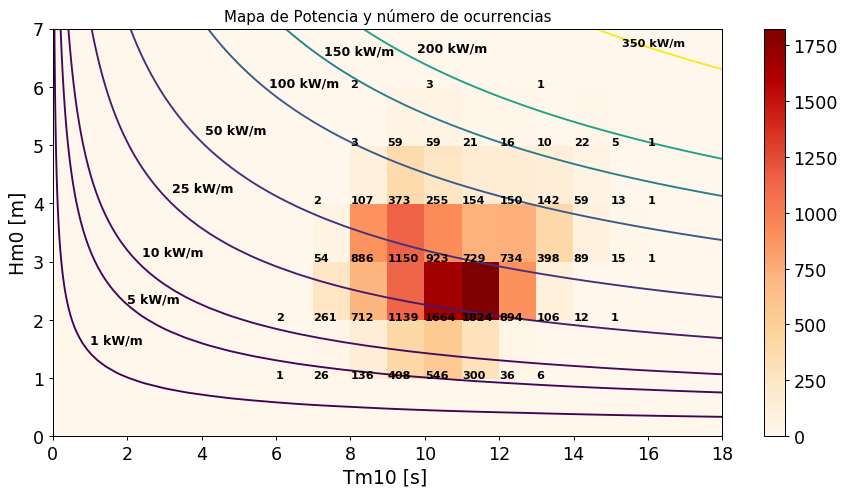

In [46]:
H= np.linspace(0,int(df['Hm0'].max())+1,num=(int(df['Hm0'].max())+2))
T = np.linspace(0,int(df['Tm10'].max())+1,num=(int(df['Tm10'].max()+2)))
dh = 0.5
dt = 0.5
coordH = []
coordT = []
Cant = []
canti = np.zeros((len(H),len(T)))
for h in H:
    for t in T:
        df_fil = df[df['Hm0']>=h]
        df_fil= df_fil[df_fil['Hm0']<h+dh]
        df_fil = df_fil[df_fil['Tm10']>=t]
        df_fil = df_fil[df_fil['Tm10']<t+dt]
        cant = len(df_fil)
        ch = h 
        ct = t 
        coordH.append(ch)
        coordT.append(ct)
        Cant.append(cant)
        canti[int(h),int(t)]=cant

import numpy as np
import matplotlib.pyplot as plt
rho= 1027 # kg/m3
g = 9.81 # m/s2
h=np.arange(0, 7.1, 0.1)
t=np.arange(0, 18.1,0.6)
H,T=np.meshgrid(h,t)
P = 0.49*(H**2)*T

fig= plt.figure(figsize=(12,6), dpi=90) 
for i in range(len(Cant)) :
    if Cant[i]!=0:
        plt.annotate(str(Cant[i]),xy=(coordT[i],coordH[i]),fontsize=9.0, weight='bold')
cs = plt.contour(T,H,P,levels=[ 1,5, 10,25,50,100,150,200,350])
plt.title('Mapa de Potencia y número de ocurrencias')
plt.xlabel('Tm10 [s] ',fontsize=15)
plt.ylabel('Hm0 [m]',fontsize=15)

plt.annotate('1 kW/m', xy = (1.0,1.6),fontsize = 10.0, weight = 'bold')
plt.annotate('5 kW/m', xy = (2.0,2.3),fontsize = 10.0, weight = 'bold')
plt.annotate('10 kW/m', xy = (2.4,3.1),fontsize = 10.0, weight = 'bold')
plt.annotate('25 kW/m', xy = (3.2,4.2),fontsize = 10.0, weight = 'bold')
plt.annotate('50 kW/m', xy = (4.1,5.2),fontsize = 10.0, weight = 'bold')
plt.annotate('100 kW/m', xy = (5.8,6),fontsize = 10.0, weight = 'bold')
plt.annotate('150 kW/m', xy = (7.3,6.55),fontsize = 10.0, weight = 'bold')
plt.annotate('200 kW/m', xy = (9.8,6.6),fontsize = 10.0, weight = 'bold')
plt.annotate('350 kW/m', xy = (15.3,6.7),fontsize = 9.0, weight = 'bold')

H= np.linspace(0,int(df['Hm0'].max())+1,num=(int(df['Hm0'].max())+2))
T = np.linspace(0,int(df['Tm10'].max())+1,num=(int(df['Tm10'].max()+2)))
x, y = np.meshgrid(T, H) 
z = canti
# x and y are bounds, so z should be the value *inside* those bounds. # Therefore, remove the last value from the z array. 
z = z[:-1, :-1] 
z_min, z_max = np.abs(z).min(), np.abs(z).max() 
#ig, ax = plt.subplots() 
c = plt.pcolormesh(x, y, z, cmap='OrRd', vmin=z_min, vmax=z_max) 
#x.set_title('pcolormesh') # set the limits of the plot to the limits of the data 
ax.axis([x.min(), x.max(), y.min(), y.max()]) 
plt.colorbar(c) 
 
plt.show()